In [25]:
%matplotlib inline
from matplotlib import style
style.use('classic')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd

In [27]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [29]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [31]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(measurement.date).\
            order_by(measurement.date.desc()).first()
print(f"Last Date: {last_date[0]}")

# Calculate the date 1 year ago from the last data point in the database
last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"One year of data begins on: {last_year_date}")

Last Date: 2017-08-23
One year of data begins on: 2016-08-23


Text(0.5, 0, 'Date')

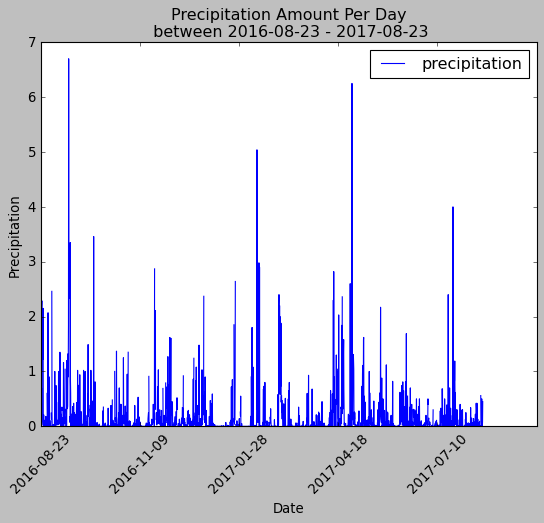

In [64]:
# Perform a query to retrieve the data and precipitation scores
measurement_cols = (measurement.date, measurement.prcp)

prcp_data = session.query(*measurement_cols).\
            filter(measurement.date >= last_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
prcp_df.head()
# Sort the dataframe by date

# Set the index to the date column and sort the dataframe by date
prcp_df.set_index('date',inplace=True)
prcp_df = prcp_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=45)
ax.set_title(f"Precipitation Amount Per Day\n between {last_year_date} - {last_date[0]}")
ax.set_ylabel("Precipitation")
ax.set_xlabel("Date")

In [36]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [37]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(station.id)).all()
station_count

[(9)]

In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_station =  session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()
count_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station == count_station[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

## Bonus Challenge Assignment

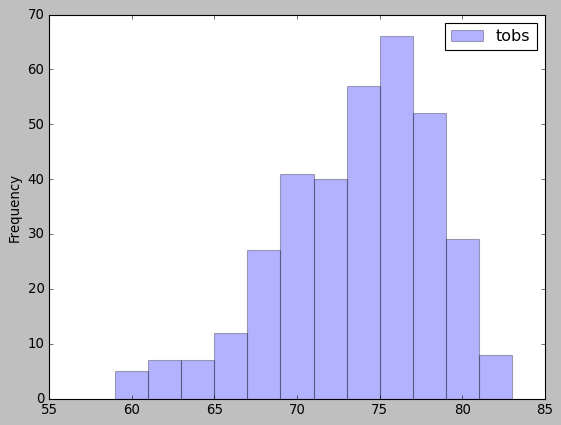

In [69]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
busy_station = session.query(measurement.date, measurement.tobs).\
                filter(measurement.station == count_station[0][0]).\
                filter(measurement.date > last_year_date).all()

busy_station_df = pd.DataFrame(busy_station)
busy_station_df.plot(kind="hist",bins=12, alpha=0.3)

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Determine start date
trip_start = '2013-07-13'
trip_end = '2013-07-25'

def last_year_dates(start_date, end_date):
    
    last_year_start_date = (dt.datetime.strptime(trip_start,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    last_year_end_date = (dt.datetime.strptime(trip_end,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    return last_year_start_date, last_year_end_date

last_start_date, last_end_date = last_year_dates(trip_start, trip_end)

tmin, tavg, tmax = calc_temps(last_start_date,last_end_date)[0]
print(tmin, tavg, tmax)

68.0 75.46153846153847 84.0


(0.0, 100.0)

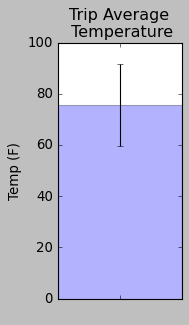

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,4))
plt.bar(x=" ", height=tavg, yerr=tmax-tmin, alpha=0.3)
plt.title("Trip Average\n Temperature")
plt.ylabel("Temp (F)")
plt.ylim(0,100)

In [44]:
# Calculate the total amount of rainfall per weather station (group) for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query_columns = [station.station, station.name, func.sum(measurement.tobs), station.latitude, 
                 station.longitude, station.elevation]

results = session.query(*query_columns).\
            group_by(station.station).\
            join(measurement, measurement.station==station.station).\
            filter(measurement.date >= last_start_date).filter(measurement.date <= last_end_date).\
            order_by(func.sum(measurement.tobs).desc()).all()

df = pd.DataFrame(results, columns=["Station", "Station_Name", "Total_Rainfall", "Latitude", "Longitude", "Elevation"])
df.sort_values("Total_Rainfall", ascending=False)
df

,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1009.0,21.31520,-157.99920,0.9
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",1006.0,21.33556,-157.71139,19.5
2,USC00519397,"WAIKIKI 717.2, HI US",1003.0,21.27160,-157.81680,3.0
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",997.0,21.52130,-157.83740,7.0
4,USC00513117,"KANEOHE 838.1, HI US",957.0,21.42340,-157.80150,14.6
5,USC00519281,"WAIHEE 837.5, HI US",945.0,21.45167,-157.84889,32.9
6,USC00516128,"MANOA LYON ARBO 785.2, HI US",938.0,21.33310,-157.80250,152.4
7,USC00517948,"PEARL CITY, HI US",612.0,21.39340,-157.97510,11.9
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",381.0,21.49920,-158.01110,306.6


In [45]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [46]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(f"Trip from {trip_start} to {trip_end}")

Trip from 2013-07-13 to 2013-07-25


In [48]:
# Use the start and end date to create a range of dates
list_of_dates = pd.date_range(trip_start, trip_end, freq='D')
# Stip off the year and save a list of %m-%d strings
month_day = list_of_dates.strftime("%m-%d")
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for date in month_day:
    normals.append(*daily_normals(date))
normals

[(69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0),
 (68.0, 75.89090909090909, 83.0),
 (69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0)]

In [50]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=["TMIN", "TAVG", "TMAX"])
df

,TMIN,TAVG,TMAX
0,69.0,76.189655,81.0
1,61.0,76.228070,82.0
2,68.0,76.254237,82.0
3,70.0,76.344828,83.0
4,70.0,76.301887,83.0
5,72.0,76.637931,83.0
6,68.0,75.890909,83.0
7,69.0,75.462963,82.0
8,69.0,76.924528,83.0
9,69.0,75.788462,81.0


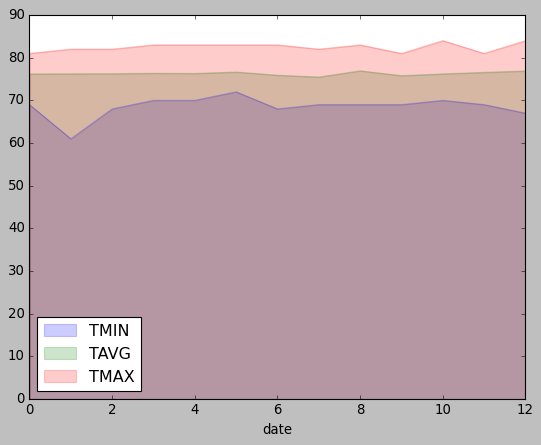

In [58]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind="area",stacked=False,alpha=.2);
plt.xlabel("date");